In [2]:
#author: Aaron Hertner
#version: python base version 3.8
#purpose: to use the Pokemon dataset, and k-means clustering algorithm, to group the pokemon together

In [3]:
import warnings

#graphing libraries
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.cbook import mplDeprecation
from matplotlib.widgets import Slider
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive
import numpy as np
import pandas as pd
import seaborn as sns

#ML Libraries
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

warnings.filterwarnings("ignore",category=mplDeprecation)

In [4]:
df = pd.read_csv('../_datasets/Pokemon.csv')

In [5]:
pd.options.display.max_columns = None
df.head()

,number,name,type1,type2,total,hp,attack,defense,sp_attack,sp_defense,speed,generation,legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,Mega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,3,Gigantamax Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [6]:
df.isnull().sum()

number          0
name            0
type1           0
type2         498
total           0
hp              0
attack          0
defense         0
sp_attack       0
sp_defense      0
speed           0
generation      0
legendary       0
dtype: int64

In [7]:
data_dropped = df.drop(['number', 'name', 'type2','total', 'generation', 'legendary'], axis=1)

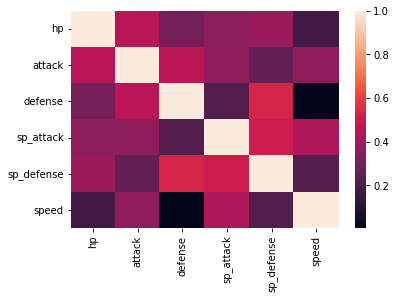

In [8]:
#determine correlation between features
sns.heatmap(data_dropped.corr())

In [9]:
#group data based on pokemon type
type_data = data_dropped.groupby('type1')
mean_type_data = type_data.mean()
mean_type_data.head()

,hp,attack,defense,sp_attack,sp_defense,speed
type1,,,,,,
Bug,57.096386,70.325301,71.518072,56.831325,65.554217,63.421687
Dark,71.312500,83.520833,67.166667,71.562500,69.062500,76.937500
Dragon,85.243902,107.024390,83.926829,91.731707,84.097561,84.341463
Electric,62.285714,74.952381,66.142857,89.539683,71.476190,85.936508
Fairy,72.608696,67.739130,70.739130,80.304348,90.565217,59.739130


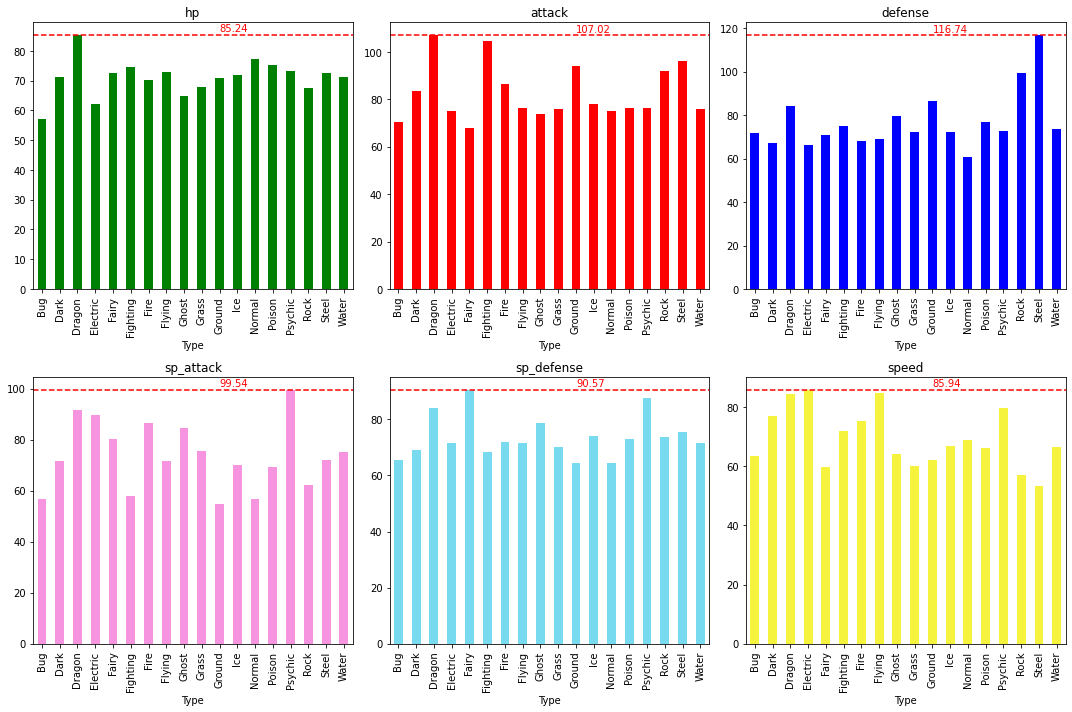

In [10]:
#determine the largest variance between classes across all features
fig, ax = plt.subplots(2,3, figsize=(15,10))
color_dic = {'hp': 'g', 
             'attack': 'r', 
             'defense': 'b', 
             'sp_attack':'#f794df', 
             'sp_defense':'#77daee', 
             'speed':'#f6f33f'}
i = 0

for feature in mean_type_data:
    bp = mean_type_data[feature].plot(ax=ax[i//3, i%3], kind = 'bar', color=color_dic[feature])
    ax[i//3, i%3].axhline(np.max(mean_type_data[feature]), c='r',linestyle='--')
    ax[i//3, i%3].text(10, np.max(mean_type_data[feature]) + 1.2, 
                       '%.2f' % np.max(mean_type_data[feature]), 
                       color='r')
    ax[i//3, i%3].set_title(feature)
    ax[i//3, i%3].set_xlabel('Type')
    i += 1

plt.tight_layout()
plt.show()

sc_df: (1072, 6)


Text(0.5, 1.0, 'Effect of n_clusters on Inertia')

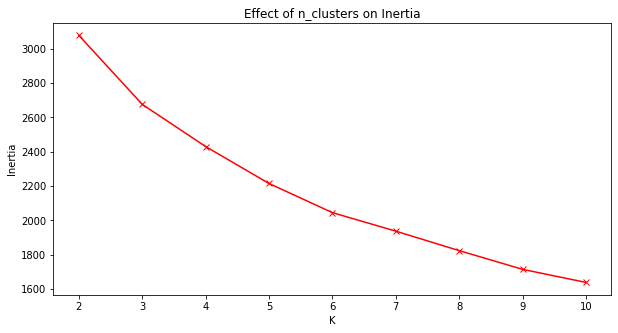

In [11]:
#Note: not required, features are close enough in scale that regularization is not necessary
feature_data = df[['hp','attack','defense','sp_attack','sp_defense','speed']]
sc = StandardScaler()
sc_df = pd.DataFrame(sc.fit_transform(feature_data), columns=feature_data.columns)
print(f'sc_df: {sc_df.shape}')

#PCA
pca = PCA(0.99)
pc_df = pca.fit_transform(sc_df)

#split data into training/testing sets
x_train, x_test = train_test_split(pc_df, test_size = 0.3, random_state = 0)

#determine optimal value of K
inertias = []

for k in range(2, 11):
    k_means = KMeans(n_clusters = k, n_init = 4)
    k_means.fit(x_train)
    inertias.append(k_means.inertia_)
    
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(range(2,11), inertias, color='r', marker='x')
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
ax.set_title('Effect of n_clusters on Inertia')

N-Clusters : 3
Inertia   : 2676.211076642448
Silhouette: 0.24732699450570492

N-Clusters : 4
Inertia   : 2429.4476229639795
Silhouette: 0.23082917025847635

N-Clusters : 5
Inertia   : 2214.2547142996123
Silhouette: 0.22483565713713907



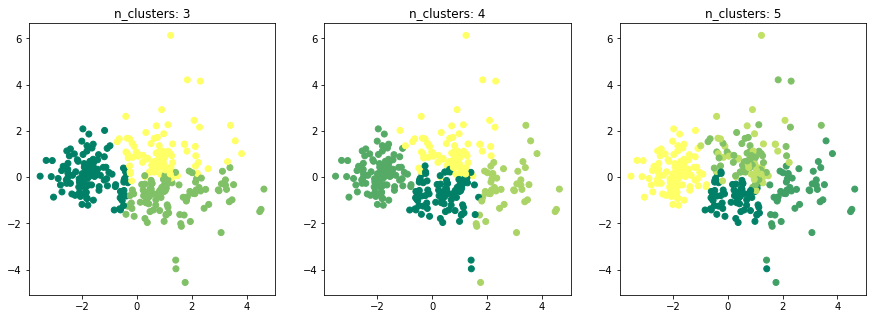

In [12]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

lowerbound = 3
for i in range(lowerbound,6):
    k_means = KMeans(n_clusters = i, n_init = 4)
    k_means.fit(x_train)
    y_pred = k_means.predict(x_test)
    plot_data = pd.DataFrame(np.c_[x_test,y_pred])
    ax[i-lowerbound].scatter(plot_data[0], plot_data[1], c=y_pred, cmap=cm.get_cmap('summer'))
    ax[i-lowerbound].set_title(f'n_clusters: {i}')
    print(f'N-Clusters : {i}')
    print(f'Inertia   : {k_means.inertia_}')
    print(f'Silhouette: {metrics.silhouette_score(x_test, y_pred)}\n')

In [ ]:
#buld and train model
k_means = KMeans(n_clusters=3, n_init=4)
k_means.fit(x_train)
y_pred = k_means.predict(x_test)

#plot in 3D
plot_data = pd.DataFrame(np.c_[x_test, y_pred])

def on_change(elevation, rotation):
    fig = plt.figure(1, figsize=(5,5))
    plt.clf()
    ax1 = fig.add_axes(Axes3D(fig, elev=elevation, azim=rotation))
    ax1.scatter(plot_data[0], plot_data[1], plot_data[2], c=y_pred, cmap = cm.get_cmap('summer'))
    plt.show()
    return elevation, rotation

interactive_plot = interactive(on_change, elevation=(0, 90, 0.1), rotation=(0, 90, 0.1))
output = interactive_plot.children[-1]
output.layout.height = '360px'
interactive_plot

NameError: name 'KMeans' is not defined